In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt 
from bandits import bandit
from bandits import bandit_arm
from multiprocessing import Pool

In [2]:
class Algorithm:
    def __init__(self, num_arms):
        self.num_arms = num_arms
    
    def give_pull(self):
        raise NotImplementedError
    
    def get_reward(self, arm_index, reward):
        raise NotImplementedError

## $\epsilon$-greedy algorithms

There are different variants of $\epsilon$-greedy algorithms, which illustrate the ideas of exploration and exploitation in reinforcement learning. Here, you are to implement an algorithm which explores with probability $\epsilon$ and exploits with probability $1-\epsilon$. Wherein, exploration means uniformly sampling from the list of arms, and exploitation is the act of sampling the arm with the highest empirical mean. 

The algorithm needs to be implemented as a class which has three functions: 
- Initialization: Initialize all the data structures (including your $\epsilon$) here. 
- Pull: Return the index of the arm that needs to be pulled as per this algorithm. 
- Get reward: The bandit instance will tell you the reward -- this function needs to update the internal data structures of the algorithm so as to process that reward.

In [3]:
# Implement the epsilon greedy algorithm 
# as a child class of the Algorithm class
class eps_greedy(Algorithm):
    def __init__(self,num_arms_):
        super().__init__(num_arms_)
        self.epsilon = 0.23 # Just selecting a random value
        self.num_arms_ = num_arms_
        self.countarr = np.zeros(num_arms_)
        self.rewarr = np.zeros(num_arms_)

        # write the necessary data structures 

    def give_pull(self):
        if np.random.random() < self.epsilon:
            return np.r11andom.choice(self.num_arms_, 1)[0]

        else:
            div = np.zeros(self.num_arms_)
            for i in range(self.num_arms_):
                if self.countarr[i] !=0 :   
                    div[i] = self.rewarr[i]/self.countarr[i]
                else:
                    div[i]= 0
            
            return np.argmax(div)
        # write the code to give a pull via the epsilon greedy algo 
    
    def get_reward(self,index,reward):
        self.countarr[index] = self.countarr[index] +1
        self.rewarr[index] = self.rewarr[index] +reward
        # update the data structures based on the reward received
        

## UCB Algorithm

Read about the UCB algorithm from Sutton and Barto, and implement it in the exact same format as the previous one. The operation to be performed is, 

$$a_t := \argmax_{a\in A}(q_t(a) + 3\sqrt{\frac{ln(t)}{N_t(a)}})$$

In [5]:
# Implement the UCB algorithm
class UCB(Algorithm):
    def __init__(self, num_arms_):
        super().__init__(num_arms_)
        self.num_arms_=num_arms_
        self.Nt=np.zeros(self.num_arms_)
        self.Qt=np.zeros(self.num_arms_)
        # write the necessary data structures here
    
    def give_pull(self):
        """div = np.zeros(self.num_arms_)
        # while i<self.num_arms_
        for i in range(self.num_arms_):
                if self.countarr[i] !=0 :   
                    div[i] = self.rewarr[i]/self.countarr[i]
                else :
                    div[i] = 0
        avg = div
        corr = np.zeros(self.num_arms_)
        for i in range(self.num_arms_):
            if self.countarr[i] !=0 :
                corr[i]= (np.sqrt(2*np.log(np.sum(self.countarr))/self.countarr[i]))
            else:
                return i
        return np.argmax(np.add(avg, corr))"""
        at=np.argmax([self.Qt[bandit]+3*np.sqrt(bandit/self.Nt[bandit]) for bandit in range(self.num_arms_)])
        return at
        # write the code to give a pull via the epsilon greedy algo 
    
    def get_reward(self,index,reward):
        self.Qt[index] +=(reward-self.Qt[index])/self.num_arms_
        self.Nt[index] +=1
        # update the data structures based on the reward received


## Thompson Sampling

This is another algorithm for sampling/pulling a MAB. Here, a list of successes ($s_t(a)$) and failures ($f_t(a)$) of the arms is maintained, and then the following samples are drawn for each arm, 

$$n_t(a) \sim \beta(s_t(a) +1,f_t(a)+1)$$

where $\beta$ denote the Beta Distribution. Then, the arm with the highest value of such a sample is chosen. That is, 
 
$$a_t := \argmax_{a\in A}n_t(a)$$

In the background, a _bayesian_ update is happening, which ensures that this algorithm works well. 

The code for this algorithm is already written, and you can use this as a reference for the structure of the other two.

In [6]:
class Thompson_Sampling(Algorithm):
    def __init__(self, num_arms):
        super().__init__(num_arms)
        #we write the required data structures for this algorithms
        self.successes = np.zeros(num_arms)
        self.failures = np.zeros(num_arms)
    
    def give_pull(self):
        # we give a rule according to the algorithm to sample the bandit instance
        beta = [np.random.beta(self.successes[bandit]+1,self.failures[bandit] +1) for bandit in range(self.num_arms)]
        return np.argmax(beta)
    
    def get_reward(self, arm_index, reward):
        # we update the data structures as we see the reward received
        self.successes[arm_index] += reward
        self.failures[arm_index] += (1-reward)


## Analysis

Here, code for the analysis of the thompson algorithm is written. Mainly, we use the _regret_ for analyzing the performance of an algorithm. The (expected cumulative) regret is the difference between the maximum possible reward and the expected reward from the algorithm. That is, 

$$R(T) := Tp^* - \sum_{t=0}^{T-1}\mathbb{E}(r_t)$$

where, $r_t$ is the reward at time $t\in\{0,1,...T-1\}$. 

We say that an algorithm here is 'good' if the regret is sub-linear, that is, 
$$\lim_{T\to\infty}\frac{R(T)}{T} = 0$$

The regret plots, along with the average reward plots for Thompson sampling are given below. Do the same for the other algorithms and compare.

In [7]:
#no need to modify anything here
def plot_avg_reward(algo,horizon,averaging=100):
    average_reward = np.zeros(horizon)
    for j in range(averaging):
        np.random.seed(0)
        bandit_instance = bandit([0.2,0.1,0.6,0.1]) # use this bandit instance only
        thompson_instance = algo(4) # do this for the other two algorithms as well
        rewards = [] 
        for i in range(horizon):
            arm_to_pull = thompson_instance.give_pull() #get the arm to pull _From the ALGORITHM_
            reward = bandit_instance.pull(arm_to_pull) #get the (stochastic) reward _from the BANDIT INSTANCE_
            thompson_instance.get_reward(arm_to_pull,reward) #update the internal data structures of the algorithm
            rewards.append(bandit_instance.avg_reward)
        average_reward = average_reward + rewards


    average_reward = average_reward/averaging 

    plt.plot(average_reward)
    plt.title("Average Reward")

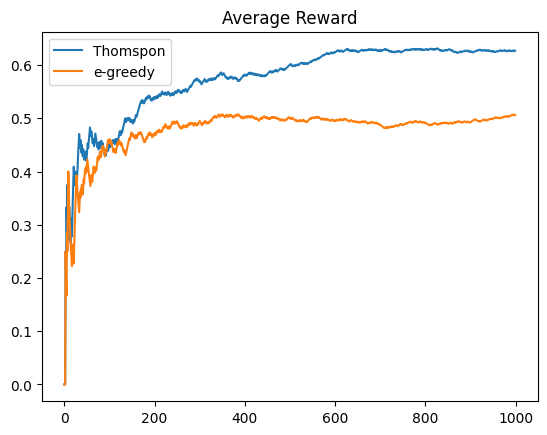

In [8]:
plot_avg_reward(Thompson_Sampling,1000)
plot_avg_reward(eps_greedy,1000) #the eps-greedy code was removed after plotting this, try to write your own and see what kind of plots you get
plt.legend(["Thomspon","e-greedy"])

In [9]:
#no need to modify anything here
def single_sim(algo, list_of_means, horizon):
    np.random.seed(0)
    bandit_instance = bandit(list_of_means=list_of_means)
    algo_inst = algo(num_arms=len(list_of_means))
    for t in range(horizon):
      arm_to_be_pulled = algo_inst.give_pull()
      reward = bandit_instance.pull(arm_to_be_pulled)
      algo_inst.get_reward(arm_index=arm_to_be_pulled, reward=reward)
    return bandit_instance.regret

def simulate(algorithm, probs, horizon, num_sims=50):

    def multiple_sims(num_sims=50):
      with Pool(10) as pool:
        regrets = pool.starmap(single_sim,
          [(algorithm, probs, horizon) for i in range(num_sims)])
      return regrets

    return np.mean(multiple_sims(num_sims))
def plot_regret(algo,list_of_means):  
  horizons = [2**i for i in range(10, 18)]
  regrets = []
  for horizon in horizons:
    regrets.append(simulate(algo, list_of_means, horizon, 20))

  print(regrets)
  plt.plot(horizons, regrets)
  plt.title("Regret vs Horizon")

In [10]:
plot_regret(Thompson_Sampling,[0.2,0.1,0.6,0.1])
plot_regret(eps_greedy,[0.2,0.1,0.6,0.1])
plt.legend(["Thomspon","e-greedy"]) #the eps-greedy code was removed after plotting this, try to write your own and see what kind of plots you get